In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import selfies as sf
from torch.utils.data import DataLoader
from tqdm import tqdm

In [2]:
data = pd.read_csv("../smiles_selfies_full.csv")

### Tokenization & Data Prep

In [3]:
df = pd.read_csv('../smiles_selfies_full.csv')
df['tokens'] = df['selfies'].apply(lambda x: list(sf.split_selfies(x)))

all_tokens =  [tok for seq in df['tokens'] for tok in seq]
vocab = sorted(set(all_tokens))
MAKS = "<MASK>"
PAD = "<PAD>"
SOS = "<SOS>"
EOS = "<EOS>"
vocab = [MAKS, PAD, SOS, EOS] + vocab
vocab_size = len(vocab)

tok2id = {tok: idx for idx, tok in enumerate(vocab)}
id2tok = {idx: tok for tok, idx in tok2id.items()}

def full_molecule_tokens_to_ids(tokens, tok2id):
    return np.array([2] + [tok2id[t] for t in tokens] + [3])

df['token_ids'] = df['tokens'].apply(lambda toks: full_molecule_tokens_to_ids(toks, tok2id))
df['lenghts'] = df['token_ids'].apply(len)

sequences = df['token_ids'].tolist()
max_len = max(len(seq) for seq in sequences)
padded_data = np.ones((len(sequences), max_len), dtype=sequences[0].dtype)

for i, seq in enumerate(sequences):
    padded_data[i, :len(seq)] = seq

data = padded_data
train_data, temp_data = train_test_split(data, test_size=0.2, random_state=42, shuffle=True)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42, shuffle=True)

print(f"Data shapes: Train {train_data.shape}, Val {val_data.shape}, Test {test_data.shape}")

Data shapes: Train (635522, 77), Val (79440, 77), Test (79441, 77)


### Model

for transformer we need query matrix W_Q (will ask questions), key matrix W_K (will be keys for questions), calculate dot product beetwen them (so we have answer how well key fits query) and then have matrix W_V that will be a linear transformation of tokens embeddings, and then each V for each token will be scaled by dot products from earlier, so we will find dependence between tokens. We also need positional encoding so model has awerness where all things are

In [34]:
class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, hidden_size):
        super().__init__()
        self.pos_emb = nn.Embedding(max_len, hidden_size)

    def forward(self, x):
        if x.dim() == 2:
            B, T = x.shape
        elif x.dim() == 3:
            B, T, _ = x.shape
        positions = torch.arange(0, T, 1, device=x.device).unsqueeze(0)
        return self.pos_emb(positions)


class MultiHeadAttention(nn.Module):
    def __init__(self, hidden_size, num_heads):
        super().__init__()
        self.d = hidden_size
        self.num_heads = num_heads
        self.W_q = nn.Linear(hidden_size, num_heads * hidden_size, bias=False)
        self.W_k = nn.Linear(hidden_size, num_heads * hidden_size, bias=False)
        self.W_v = nn.Linear(hidden_size, num_heads * hidden_size, bias=False)
        self.W_o = nn.Linear(num_heads * hidden_size, hidden_size, bias=False)
        self.norm1 = nn.LayerNorm(hidden_size)
        self.ff = nn.Sequential(
            nn.Linear(hidden_size, 4*hidden_size),
            nn.ReLU(),
            nn.Linear(4*hidden_size, hidden_size)
        )
        self.norm2 = nn.LayerNorm(hidden_size)

    def forward(self, x):   # [B, T, H]
        B, T, H = x.shape
        Q = self.W_q(x)     # [B, T, num_heads * H]
        K = self.W_k(x)
        V = self.W_v(x)
        Q = Q.view(B, self.num_heads, T, H) # [B, A, T, H]
        K = K.view(B, self.num_heads, T, H)
        V = V.view(B, self.num_heads, T, H)

        attn_logits = torch.einsum('bath,bahT->batT', Q, K.transpose(2,3))    # [B, A, T, H] @ [B, A, H, T] = [B, A, T, T]
        attn = F.softmax(attn_logits / (H ** 0.5), dim=-1)   
        h = torch.einsum('batt,bath->bath',attn, V)  # [B, A, T, H]
        h = h.view(B, T, self.num_heads*H)  # [B, T, A*H]
        h = self.W_o(h)     # [B, T, H]
        
        h = self.norm1(x + h)
        h = self.norm2(h + self.ff(h))
        return h

class VaeTransformer(nn.Module):
    def __init__(self, vocab_size, hidden_size, latent_size, max_len, attn_heads=10, mask_token_id=0, seed_size=5):
        super().__init__()
        # Encoder
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.pos_encoder = PositionalEmbedding(max_len, hidden_size)
        # Self Attention on embeddings
        self.encoder = MultiHeadAttention(hidden_size, attn_heads)
        # Attention Pooling matrix
        self.W_pool = nn.Linear(hidden_size, hidden_size)
        # vae heads
        self.fc_mu = nn.Linear(hidden_size, latent_size)
        self.fc_logvar = nn.Linear(hidden_size, latent_size)

        # Decoder
        self.max_len = max_len
        self.seed_size = seed_size
        self.fc_seed = nn.Linear(latent_size, seed_size * hidden_size)
        # Self attention on masked sequences
        self.start_T = 5
        self.fc_z = nn.Linear(latent_size, self.start_T * hidden_size)
        self.decoder = nn.Sequential(
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(hidden_size, hidden_size, kernel_size=7, stride=1, padding=3)
        )   
        # output head
        self.fc_output = nn.Linear(hidden_size, vocab_size)

    def encode(self, x):  
        h = self.embedding(x)    # [B, T, H]
        pos_encoding = self.pos_encoder(x)
        h += pos_encoding
        h = self.encoder(h)
        h = torch.mean(h, dim=-2)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def decode(self, z):
        B = z.size(0)
        h = self.fc_z(z)
        h = h.view(B, self.hidden_size, self.start_T)
        h = self.decoder(h)            # [B, H, T]
        h = h[:, :, :self.max_len]
        logits = self.fc_output(h.transpose(1, 2))  # [B, T, vocab]
        return logits
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        std = torch.exp(logvar)
        eps = torch.randn_like(mu)
        z = mu + std * eps
        logits = self.decode(z)
        return logits, mu, logvar
    
def vae_loss(logits, x, mu, logvar, beta=0.01, pad_id=1):
    B, T, V = logits.shape
    logits_flat = logits.reshape((B*T, V))
    targets_flat = x.reshape(B*T)

    mask = (targets_flat != pad_id)
    valid_logits = logits_flat[mask]
    valid_targets = targets_flat[mask]

    rec_loss = F.cross_entropy(valid_logits, valid_targets)
    kl_loss = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    loss = rec_loss + beta * kl_loss
    return loss, rec_loss, kl_loss

### Train

In [35]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

hidden_size = 128
latent_size = 128
attention_heads = 8

model = VaeTransformer(vocab_size, hidden_size, latent_size, max_len, attention_heads).to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3)

beta = 0.01
epochs = 10
batch_size = 256
history = []

train_loader = DataLoader(train_data, batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size, shuffle=False)

for epoch in range(1, epochs+1):
    model.train()
    total = 0
    total_rec = 0
    total_kl = 0

    for x in tqdm(train_loader):
        x = x.to(device)
        logits, mu, logvar = model(x)
        loss, rec, kl = vae_loss(logits, x, mu, logvar, beta)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total += loss.item()
        total_rec += rec.item()
        total_kl += kl.item()

    total = total / len(train_loader)
    total_rec = total_rec / len(train_loader)
    total_kl = total_kl / len(train_loader)
    history.append((total, total_rec, total_kl))
    print(f"Epoch: {epoch:03d} | total={total:.4f} | rec={total_rec:.4f} | kl={total_kl:.4f}")

  0%|          | 0/2483 [00:00<?, ?it/s]

100%|██████████| 2483/2483 [01:20<00:00, 31.02it/s]


Epoch: 001 | total=1.8219 | rec=1.8120 | kl=0.9853


100%|██████████| 2483/2483 [01:20<00:00, 30.89it/s]


Epoch: 002 | total=1.0986 | rec=1.0816 | kl=1.6937


100%|██████████| 2483/2483 [01:20<00:00, 30.91it/s]


Epoch: 003 | total=0.7365 | rec=0.7180 | kl=1.8498


100%|██████████| 2483/2483 [01:20<00:00, 30.93it/s]


Epoch: 004 | total=0.5675 | rec=0.5485 | kl=1.9034


100%|██████████| 2483/2483 [01:20<00:00, 30.87it/s]


Epoch: 005 | total=0.4583 | rec=0.4389 | kl=1.9394


100%|██████████| 2483/2483 [01:20<00:00, 30.88it/s]


Epoch: 006 | total=0.3797 | rec=0.3600 | kl=1.9666


100%|██████████| 2483/2483 [01:20<00:00, 30.92it/s]


Epoch: 007 | total=0.3200 | rec=0.3002 | kl=1.9845


100%|██████████| 2483/2483 [01:20<00:00, 30.96it/s]


Epoch: 008 | total=0.2645 | rec=0.2445 | kl=1.9980


100%|██████████| 2483/2483 [01:20<00:00, 30.97it/s]


Epoch: 009 | total=0.2211 | rec=0.2011 | kl=2.0013


100%|██████████| 2483/2483 [01:20<00:00, 30.94it/s]

Epoch: 010 | total=0.1943 | rec=0.1743 | kl=2.0033


[]

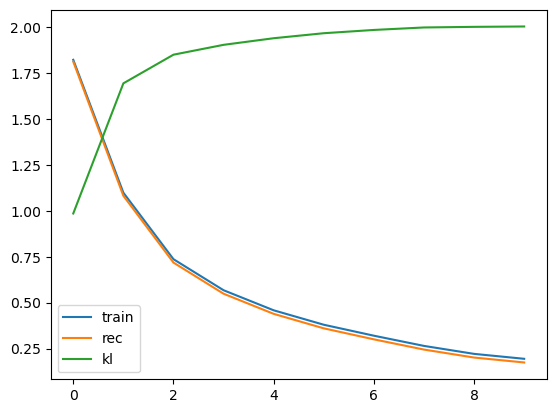

In [36]:
history_np = np.array(history)
plt.plot(history_np[:, 0], label='train')
plt.plot(history_np[:, 1], label='rec')
plt.plot(history_np[:, 2], label='kl')
plt.legend()
plt.plot()

In [37]:
zs = []
model.eval()
with torch.no_grad():
    for x in val_loader:
        x = x.to(device)
        mu, logvar = model.encode(x)
        zs.append(mu)
z = torch.cat(zs, dim=0).cpu().numpy()

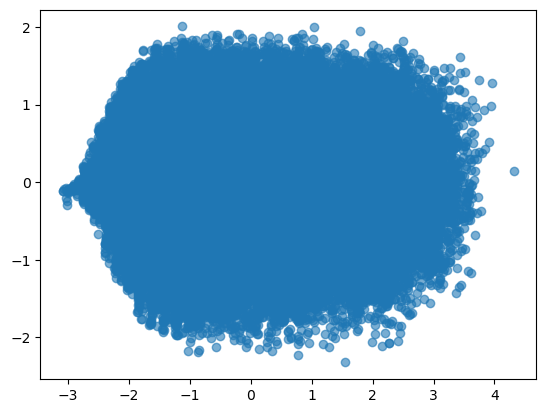

In [38]:
pca_z = PCA().fit_transform(z)
plt.scatter(pca_z[:, 0], pca_z[:, 1], alpha=0.6)
plt.show()

In [39]:
def tokens_to_selfie(tokens):
    selfie_tokens = [id2tok[int(id)] for id in tokens]
    return str(selfie_tokens)

In [40]:
x = val_data[0:1]
print(x.shape)
x = torch.tensor(x, device=device)
logits, mu, logvar = model(x)
print(logits.shape)
tokens = torch.argmax(logits, dim=-1)
print(tokens_to_selfie(x[0]))
print(tokens_to_selfie(tokens[0]))

(1, 77)
torch.Size([1, 77, 111])
['<SOS>', '[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[#Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', '[=N]', '[N]', '[Ring2]', '[Ring1]', '[Ring2]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Ring1]', '[=Branch1]', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
['<SOS>', '[C]', '[C]', '[C]', '[C]', '[=C]', '[Branch2]', '[Ring1]', '[Branch2]', '[C]', '[=Branch1]', '[C]', '[=O]', '[N]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '[C]', '[=C]', '[Branch1]', '[C]', '[O]', '[C]', '[=C]', '[C]', '[Ring1]', '[Branch1]', '[=C]', '[Ring1]', '[O]', '[C]', '

In [ ]:
# def check_rec(model, data, num_samples=5, device='cuda'):
#     for i in range(num_samples):
#         idx = np.random.randint(0, len(data))
#         x = data[idx]
#         x = x.to(device)
#         logits, 

In [41]:
def accuracy(model, loader, pad_id=1, device='cuda'):
    model.eval()
    for x in loader:
        x = x.to(device)
        logits, mu, logvar = model(x)
        preds = torch.argmax(logits, dim=-1)
        mask = (x != pad_id)
        correct_tokens = (preds == x) & mask
        token_acc = correct_tokens.sum().float() / (mask.sum().float() + 1e-8)
        seq_correct = ((preds == x) | ~mask).all(dim=1)
        seq_acc = seq_correct.float().mean()
    return token_acc, seq_acc

In [42]:
token_acc, seq_acc = accuracy(model, val_loader)
print(f'token_acc={token_acc}')
print(f'seq_acc={seq_acc}')

token_acc=0.9343840479850769
seq_acc=0.2750000059604645
